In [1]:
import pyross.tsi as pyrosstsi 
import numpy as np
from scipy.integrate import cumtrapz
from scipy.integrate import trapz
from scipy.special import gamma
from scipy.special import gammainc
from scipy.optimize import newton

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

## TSI models with gamma-distributed recovery times
This notebook solves TSI models with delta-distributed recovery times.  Infectiousness is not assumed to be a function of time since infection except to the extent that the infectious population decreases over time.

By eye, the results are in agreement with previously reported studies of the same model

http://wrap.warwick.ac.uk/72035/1/WRAP_Simple_approximations_epidemics..pdf

In [2]:
#############################
## Disease Characteristics ##
#############################

R0 = 1.5                                    # Reproduction number
T = 2                                     # Longest  infectious duration (units of T, per Fowler's notation)
            
Tf = 80.                                    # Simulation end time

    
##############################
##   Miscellaneous Details  ##
##############################

M = 2                                        # Number of age groups to model
                                             # pyross TSI has bugs for M = 1, will fix soon.
Ni = np.ones(M)                              # Number of people in each age group
Np = sum(Ni)                                 # Total population size

Nk = 1000; NL = 10
def contactMatrix(t): return 1/M*np.ones((M,M))

subclasses = ['Recovered']  
pR = np.ones(M);  #probability of eventually recovering for each age class

s = np.array([0, T - .01, T])                  # time since infection
phiR = np.array([0,0,1])                         # Probability density for recovery
phiR = phiR/trapz(phiR,s)


#group them all together for later processing
phi_alpha, p_alpha = np.array([phiR]), np.array([pR])


#######################
## Processing Inputs ##
#######################

beta = np.array([1, 1, 0])                     # Computing beta(s) from gamma distributed residence times

lam = newton(lambda x: R0*(1-np.exp(-x))-x,R0-1)  # Linear growth rate
Td = np.log(2)/lam*T                           # Doubling time (preferred input to pyrosstsi)





In [3]:
parameters = {'M':M, 'Ni':Ni, 'Nc':len(subclasses), 'Nk':Nk, 'NL':NL, 'Tf':Tf, 'Tc':(T/2), 'T':T, 'Td':Td,
              'tsi':s,'beta':beta,'tsi_sc':s, 'phi_alpha':phi_alpha, 'p_alpha':p_alpha, 
              'contactMatrix':contactMatrix}

model = pyrosstsi.deterministic.Simulator(parameters,'Galerkin')#,'Crank Nicolson')
IC    = model.get_IC()
S_0, I_0, Ic_0 = IC
I_0 = 10**-2.9*I_0/np.trapz(np.sum(I_0,1),np.linspace(-1,1,len(I_0)))
IC = [S_0, I_0, Ic_0]

data  = model.simulate(IC)#,10**-3*4, 10**-2*4)

/data/septal/rs2004/software/anaconda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


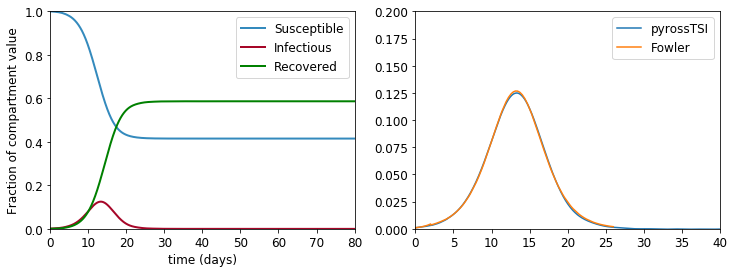

In [4]:
#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; Ic_t = data['Ic_t']; I_t_all = data['I_t']

I_t = 1 + 1e-3- (np.sum(S_t,0)+np.sum(Ic_t[0,:,:],0))

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,I_t          , color="#A60628", lw=2, label = 'Infectious')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  plt.ylim(0,1)
plt.ylabel('Fraction of compartment value');   plt.legend()


# Infection Curve, for comparison with Figures in Fowler
plt.subplot(122) 
plt.plot(t,I_t, label = 'pyrossTSI')

data_f = np.genfromtxt('soper_R0_1,5.dat', delimiter='    ', skip_header=1)
plt.plot(data_f[:,0],data_f[:,2]/1.5, label = 'Fowler')

plt.xlim(0,40); plt.ylim(0,.2)
plt.legend()

## Fowler Figure for Comparison:
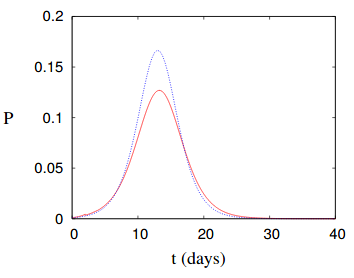